In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install mne
# !pip install Pywavelets

In [2]:
import numpy as np
from scipy.signal import butter, lfilter
from sklearn.cross_decomposition import CCA
import mne
import pywt

# Load the epochs
epochs = mne.read_epochs("combined-epo.fif")

epochs.filter(6,64, method='iir', iir_params=dict(order=5, ftype='butter'))
# implementing ICA

from mne.preprocessing import ICA

# Define ICA parameters
n_components = 3 # Number of ICA components to compute
method = 'fastica'  # The ICA method to use ('fastica' is common)

# Initialize the ICA object
ica = ICA(n_components=n_components, method=method, random_state=97)
# Fit the ICA model to the epochs data
ica.fit(epochs)
# Apply the ICA solution to the epochs data
epochs = ica.apply(epochs.copy())


Reading C:\Users\dhanu\Desktop\Caps\code\combined-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1050 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 6 - 64 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 6.00, 64.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 3 channels (please be patient, this may take a while)


C:\Users\dhanu\AppData\Local\Temp\ipykernel_17328\2399211574.py:22: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 3 components
Fitting ICA took 3.4s.
Applying ICA to Epochs instance
    Transforming to ICA space (3 components)
    Zeroing out 0 ICA components
    Projecting back using 3 PCA components


C:\Users\dhanu\AppData\Local\Temp\ipykernel_17328\2399211574.py:24: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs = ica.apply(epochs.copy())


In [3]:

# Bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

# Filter bank definitions
filter_bank = [
    {'low': 6, 'high': 18},
    {'low': 14, 'high': 36},
    {'low': 28, 'high': 64}
]

# Function to generate reference signals
def generate_reference_signals(frequencies, sfreq, n_samples):
    t = np.arange(n_samples) / sfreq
    ref_signals = []
    for freq in frequencies:
        ref_signals.append(np.sin(2 * np.pi * freq * t))
        ref_signals.append(np.cos(2 * np.pi * freq * t))
    return np.array(ref_signals).T

# Function to apply DWT
def apply_dwt(data, wavelet='db4'):
    coeffs = pywt.wavedec(data, wavelet, level=4)
    return coeffs

# Function to perform FBCCA with DWT
def fbcca_with_dwt(epochs, frequencies, sfreq, n_samples, filter_bank, wavelet='db4'):
    cca = CCA(n_components=1)
    n_epochs = epochs.shape[0]
    n_channels = epochs.shape[1]

    dwt_results_1 = []
    dwt_results_2 = []
    dwt_results_3 = []

    for epoch_idx in range(n_epochs):
        epoch_data = epochs[epoch_idx]
        epoch_dwt_coeffs_1 = []
        epoch_dwt_coeffs_2 = []
        epoch_dwt_coeffs_3 = []

        for freq in frequencies:
            filtered_data_fb1 = np.zeros((n_channels, n_samples))
            filtered_data_fb2 = np.zeros((n_channels, n_samples))
            filtered_data_fb3 = np.zeros((n_channels, n_samples))

            for ch in range(n_channels):
                filtered_data_fb1[ch, :] = bandpass_filter(epoch_data[ch, :], filter_bank[0]['low'], filter_bank[0]['high'], sfreq)
                filtered_data_fb2[ch, :] = bandpass_filter(epoch_data[ch, :], filter_bank[1]['low'], filter_bank[1]['high'], sfreq)
                filtered_data_fb3[ch, :] = bandpass_filter(epoch_data[ch, :], filter_bank[2]['low'], filter_bank[2]['high'], sfreq)

            filtered_data_fb1 = filtered_data_fb1.T
            filtered_data_fb2 = filtered_data_fb2.T
            filtered_data_fb3 = filtered_data_fb3.T
            ref_signals = generate_reference_signals([freq], sfreq, n_samples)

            fb1_data, Y_c = cca.fit_transform(filtered_data_fb1, ref_signals)
            fb2_data, Y_c = cca.fit_transform(filtered_data_fb2, ref_signals)
            fb3_data, Y_c = cca.fit_transform(filtered_data_fb3, ref_signals)

            # Apply DWT to the canonical variates X_c
            coeffs_1 = apply_dwt(fb1_data.flatten(), wavelet)
            coeffs_2 = apply_dwt(fb2_data.flatten(), wavelet)
            coeffs_3 = apply_dwt(fb3_data.flatten(), wavelet)

            cD5_1 = coeffs_1[1]  # Get the level 5 detail coefficients
            cD5_2 = coeffs_2[1]  # Get the level 5 detail coefficients
            cD5_3 = coeffs_3[1]  # Get the level 5 detail coefficients

            # Store the level 5 detail coefficients for the current frequency
            epoch_dwt_coeffs_1.append(cD5_1)
            epoch_dwt_coeffs_2.append(cD5_2)
            epoch_dwt_coeffs_3.append(cD5_3)

        # Store the results for the current epoch
        dwt_results_1.append(epoch_dwt_coeffs_1)
        dwt_results_2.append(epoch_dwt_coeffs_2)
        dwt_results_3.append(epoch_dwt_coeffs_3)

    return np.array(dwt_results_1), np.array(dwt_results_2), np.array(dwt_results_3)


In [4]:
frequencies = [8, 9, 10, 11, 12]
sfreq = 250
n_samples_per_epoch = 1500

# Get the data from epochs (n_epochs, n_channels, n_times)
epochs_data = epochs.get_data(copy=False)

one , two, three = fbcca_with_dwt(epochs_data, frequencies, sfreq, n_samples_per_epoch, filter_bank)

one.shape, two.shape, three.shape

((1050, 5, 100), (1050, 5, 100), (1050, 5, 100))

In [5]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = one
# Assuming 'one' contains the DWT coefficients and labels are obtained from epochs.events
labels = epochs.events[:, -1]-1

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data and labels to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int64)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int64)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int64)


In [6]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Reshape the data for Random Forest (samples, features)
X_train_reshaped = X_train.numpy().reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.numpy().reshape(X_val.shape[0], -1)
X_test_reshaped = X_test.numpy().reshape(X_test.shape[0], -1)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_reshaped, y_train.numpy())

# Make predictions on the validation set
y_val_pred = rf_classifier.predict(X_val_reshaped)

# Evaluate the performance on the validation set
val_accuracy = accuracy_score(y_val.numpy(), y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Make predictions on the test set
y_test_pred = rf_classifier.predict(X_test_reshaped)

# Evaluate the performance on the test set
test_accuracy = accuracy_score(y_test.numpy(), y_test_pred)
print("Test Accuracy:", test_accuracy)


Validation Accuracy: 0.7961783439490446
Test Accuracy: 0.7658227848101266


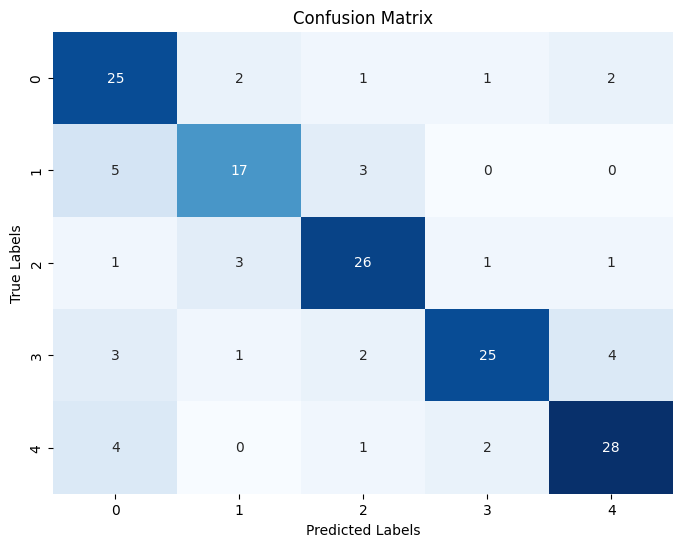

In [7]:


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_test_pred = rf_classifier.predict(X_test_reshaped)

# Generate confusion matrix
cm = confusion_matrix(y_test.numpy(), y_test_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Test Accuracy for fold: 0.7619


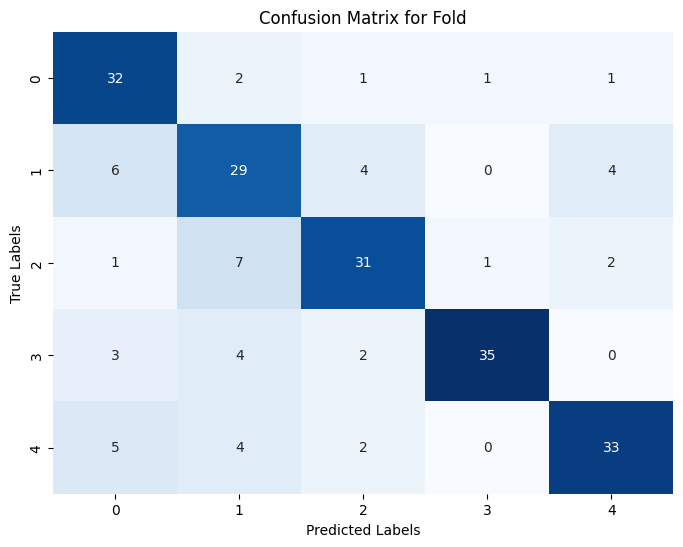

Test Accuracy for fold: 0.7714


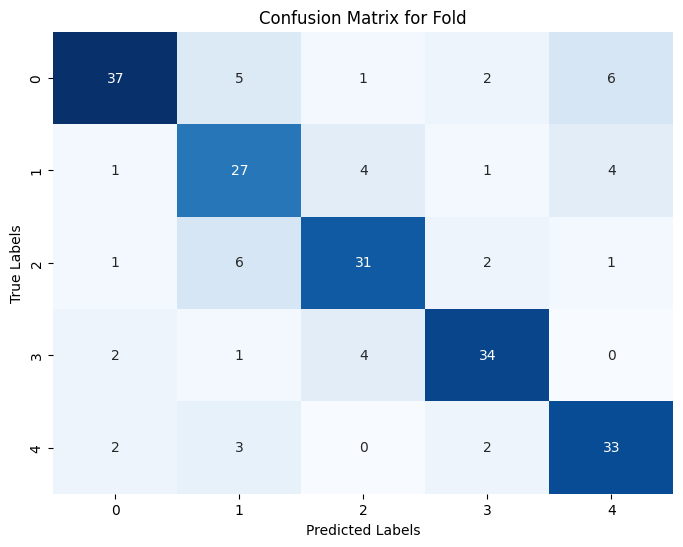

Test Accuracy for fold: 0.7810


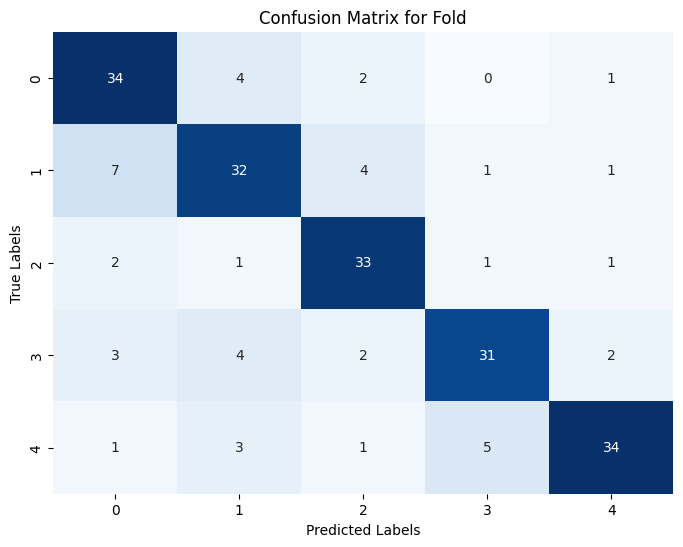

Test Accuracy for fold: 0.7905


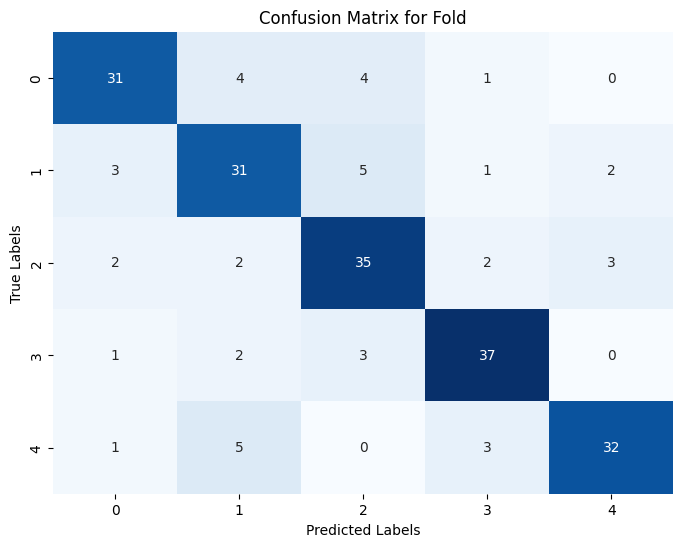

Test Accuracy for fold: 0.8000


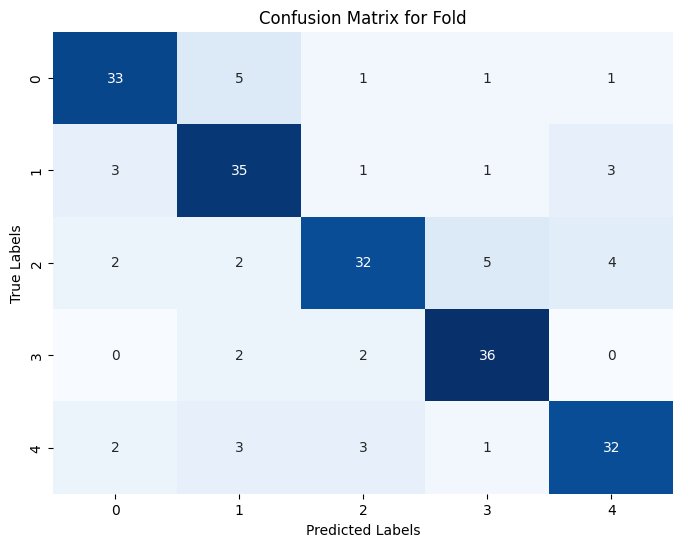

Average Test Accuracy: 0.7809523809523808


In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'one' contains the DWT coefficients and labels are obtained from epochs.events
labels = epochs.events[:, -1]-1
# Reshape data: Flatten the last two dimensions
X_prime = np.concatenate((one,two,three),axis=-1)
X = X_prime.reshape(1050, -1)  # Shape: (1050, 500)

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store accuracy for each fold
val_accuracies = []
test_accuracies = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Initialize Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the classifier
    rf_classifier.fit(X_train, y_train)

    # Make predictions
    y_test_pred = rf_classifier.predict(X_test)

    # Evaluate performance
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    print(f"Test Accuracy for fold: {test_accuracy:.4f}")

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Fold')
    plt.show()

# Print average accuracy across all folds
print("Average Test Accuracy:", np.mean(test_accuracies))
